<a href="https://colab.research.google.com/github/hyg03/20242R0136COSE47402/blob/main/FinalProject/ensemble1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

**PyTorch** is used for model building, training, and optimization. **torchvision** is used for pre-trained models, data transformations, and dataset loading. **matplotlib** and **numpy** are needed for visualization and numerical operations.

In [ ]:
!pip install kaggle

In [ ]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 37.9 MB/s eta 0:00:00


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import vit_b_16
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import optuna
import matplotlib.pyplot as plt
import numpy as np
import torch.cuda.amp as amp
import torchxrayvision as xrv

# Importing the dataset

In [47]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"yhag03","key":"bca7d5320bd827e30564d6b207ef85cb"}'}

In [48]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [49]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [50]:
!unzip chest-xray-pneumonia.zip -d ./dataxrays

Streaming output truncated to the last 5000 lines.
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./dataxrays/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: ./dataxrays/ch

# Preprocess Dataset

In [51]:
# Dataset preprocessing
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='./dataxrays/chest_xray/train', transform=data_transform)
val_dataset = datasets.ImageFolder(root='./dataxrays/chest_xray/val', transform=data_transform)
test_dataset = datasets.ImageFolder(root='./dataxrays/chest_xray/test', transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)

Classes: ['NORMAL', 'PNEUMONIA']


# Loading pre-trained models

In [52]:
# Load pre-trained models
resnet50 = models.resnet50(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
vit_model = vit_b_16(pretrained=True)

resnet50.fc = nn.Identity()
densenet121.classifier = nn.Identity()
vit_model.heads = nn.Identity()

resnet50 = resnet50.to('cuda').eval()
densenet121 = densenet121.to('cuda').eval()
vit_model = vit_model.to('cuda').eval()

# Defining the Cross-Attention Mechanism

In [53]:
class CrossAttention(nn.Module):
  def __init__(self, feature_dim, num_heads=4, dropout=0.3):
    super(CrossAttention, self).__init__()
    self.query = nn.Linear(feature_dim, feature_dim)
    self.key = nn.Linear(feature_dim, feature_dim)
    self.value = nn.Linear(feature_dim, feature_dim)
    self.dropout = nn.Dropout(dropout)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, features):
    Q = self.query(features)
    K = self.key(features)
    V = self.value(features)

    attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(features.size(-1))
    attention_weights = self.dropout(self.softmax(attention_scores))
    attention_output = torch.matmul(attention_weights, V)

    return attention_output.mean(dim=1)

# Defining the Ensemble Model

In [54]:
class WeightedEnsembleModel(nn.Module):
  def __init__(self, models, weights, feature_dim, num_classes=2):
    super(WeightedEnsembleModel, self).__init__()
    self.models = models
    self.weights = weights
    self.projections = nn.ModuleList([
        nn.Linear(model_dim, feature_dim) for model_dim in [2048, 1024, 768]
    ])
    self.cross_attention = CrossAttention(feature_dim)
    self.fc = nn.Linear(feature_dim, num_classes)

  def forward(self, x):
    features = []
    for i, model in enumerate(self.models):
      with torch.no_grad():
        raw_features = model(x)
        features.append(self.weights[i] * self.projections[i](raw_features))
    features = torch.stack(features, dim=1)
    fused_features = self.cross_attention(features)
    output = self.fc(fused_features)
    return output

# Training and Validation

In [55]:
scaler = amp.GradScaler()

ensemble_model = WeightedEnsembleModel(
    models=[resnet50, densenet121, vit_model],
    weights=[0.3, 0.4, 0.3],
    feature_dim=512,
    num_classes=2
).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=1e-4, weight_decay=1e-5)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
  ensemble_model.train()
  running_loss, correct, total = 0, 0, 0

  for images, labels in train_loader:
    images, labels = images.to('cuda'), labels.to('cuda')
    optimizer.zero_grad()

    with amp.autocast():
      outputs = ensemble_model(images)
      loss = criterion(outputs, labels)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_acc = 100 * correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  ensemble_model.eval()
  running_val_loss, correct_val, total_val = 0, 0, 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to('cuda'), labels.to('cuda')
      outputs = ensemble_model(images)
      loss = criterion(outputs, labels)

      running_val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total_val += labels.size(0)
      correct_val += (predicted == labels).sum().item()

  val_loss = running_val_loss / len(val_loader)
  val_acc = 100 * correct_val / total_val
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1 - Train Loss: 0.4190, Train Acc: 81.17%, Val Loss: 0.4771, Val Acc: 81.25%
Epoch 2 - Train Loss: 0.1899, Train Acc: 92.56%, Val Loss: 0.3218, Val Acc: 81.25%
Epoch 3 - Train Loss: 0.1686, Train Acc: 92.89%, Val Loss: 0.3219, Val Acc: 81.25%
Epoch 4 - Train Loss: 0.1446, Train Acc: 94.46%, Val Loss: 0.3368, Val Acc: 87.50%
Epoch 5 - Train Loss: 0.1289, Train Acc: 95.11%, Val Loss: 0.3713, Val Acc: 87.50%
Epoch 6 - Train Loss: 0.1268, Train Acc: 95.17%, Val Loss: 0.2110, Val Acc: 93.75%
Epoch 7 - Train Loss: 0.1153, Train Acc: 95.17%, Val Loss: 0.3760, Val Acc: 87.50%
Epoch 8 - Train Loss: 0.1080, Train Acc: 95.55%, Val Loss: 0.2975, Val Acc: 93.75%
Epoch 9 - Train Loss: 0.1053, Train Acc: 95.82%, Val Loss: 0.3356, Val Acc: 87.50%
Epoch 10 - Train Loss: 0.1017, Train Acc: 95.78%, Val Loss: 0.2797, Val Acc: 87.50%


# Metrics and Visualizations

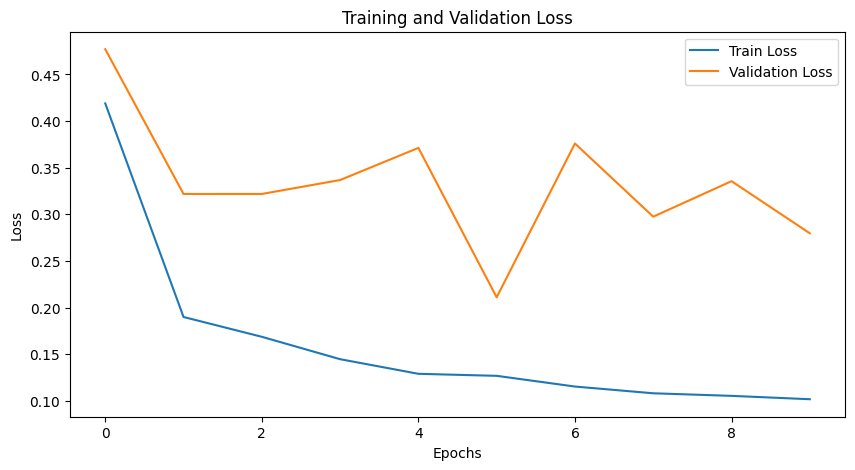

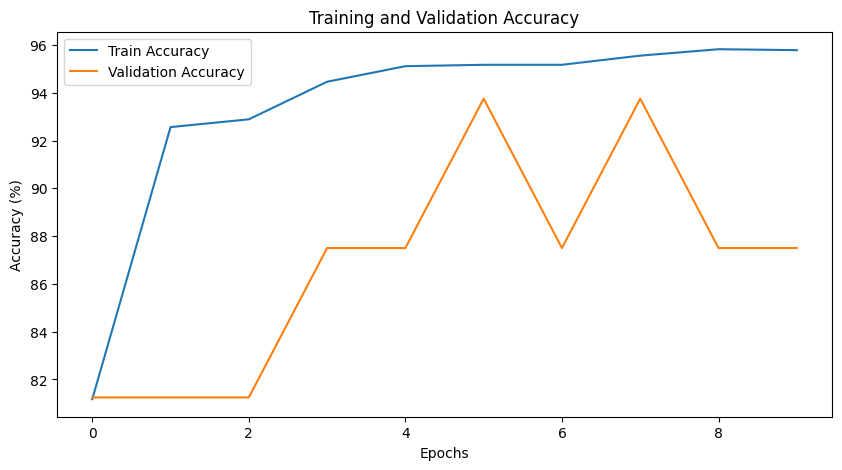

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

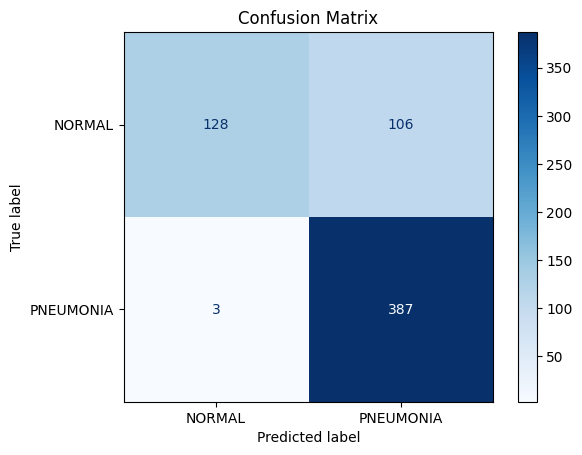

In [57]:
ensemble_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to('cuda'), labels.to('cuda')
    outputs = ensemble_model(images)
    _, predicted = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()